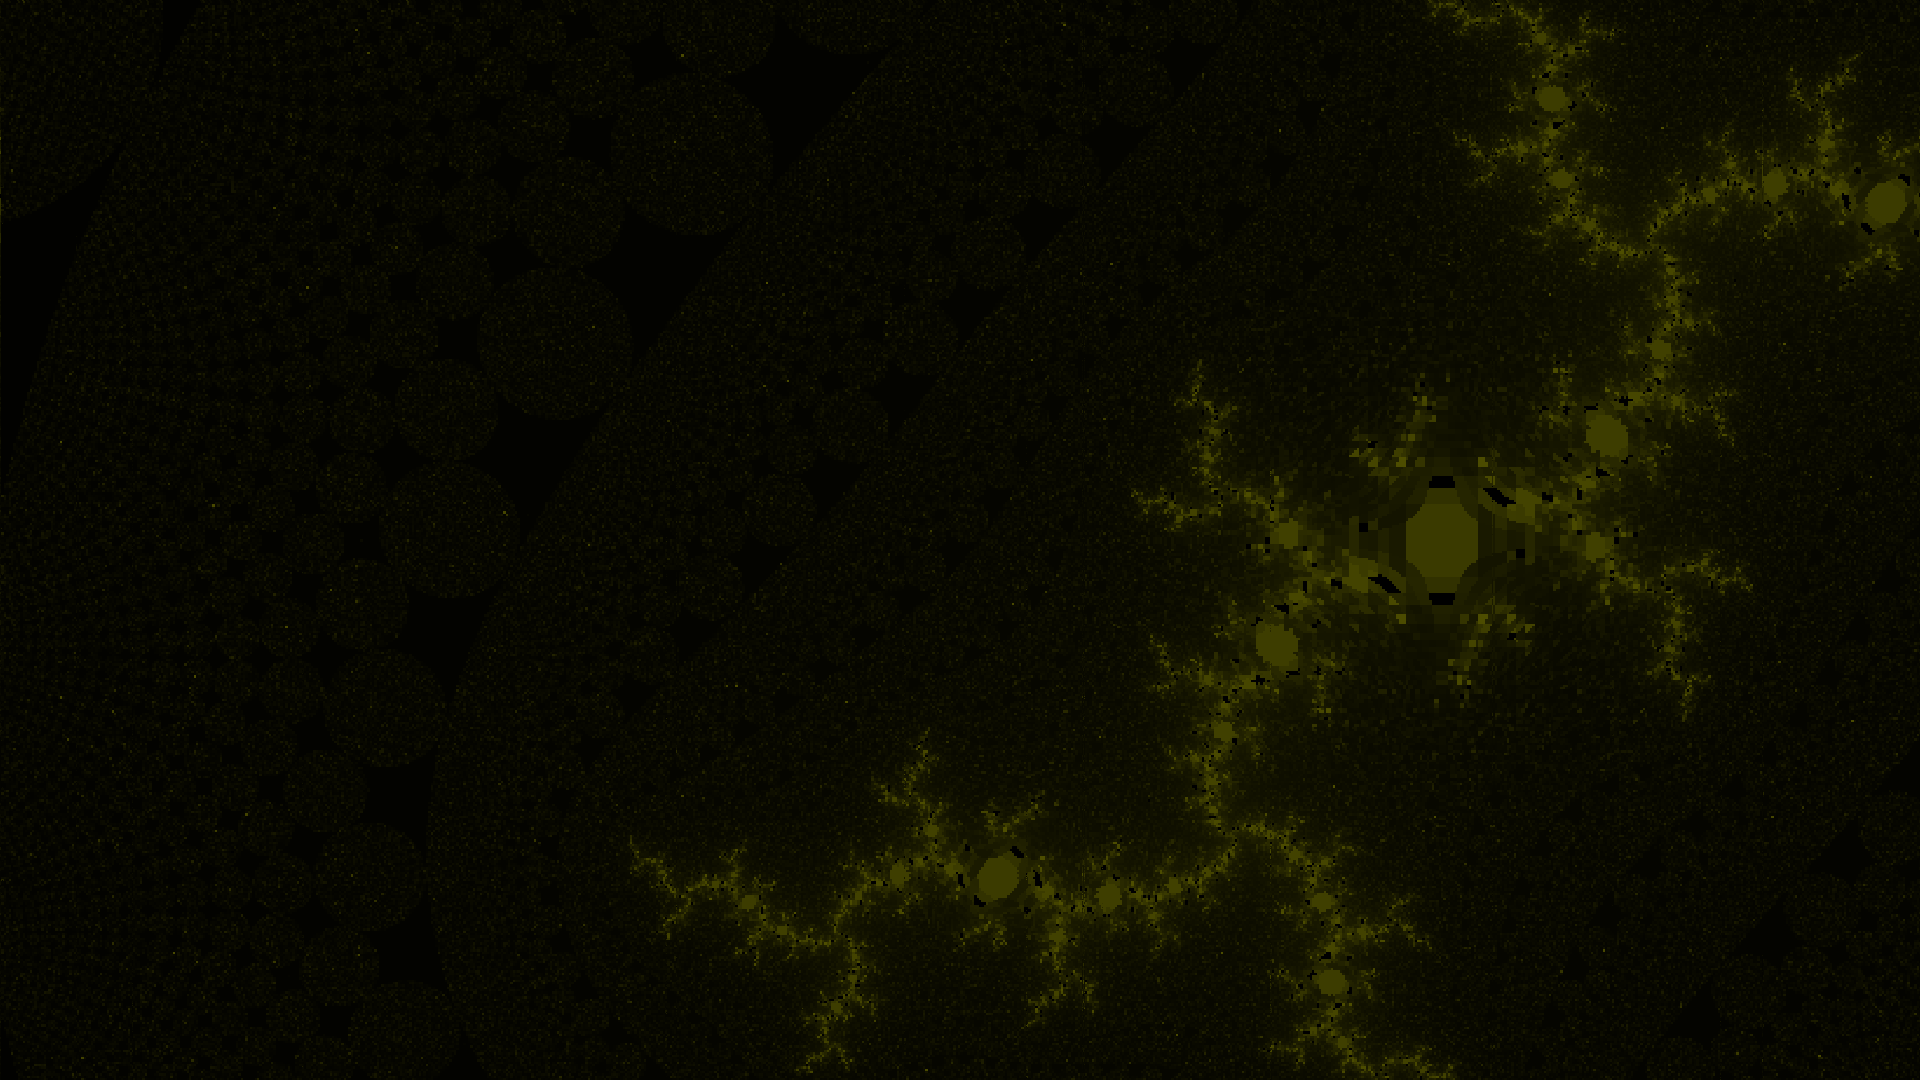

In [1]:
# <codecell>
from pynq import Overlay
from pynq.lib.video import *
overlay = Overlay("/home/xilinx/jupyter_notebooks/base.bit")
import asyncio
import nest_asyncio
import time
imgen_vdma = overlay.video.axi_vdma_0.readchannel
videoMode = common.VideoMode(1920, 1080, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

pixgen = overlay.pixel_generator_0
pixgen.register_map.gp5 = 0x19A00E6 #OFFSET for JUlia
pixgen.register_map.gp6 = 0x26600E6
pixgen.register_map.gp7 = 0x33301CD
import PIL.Image


frame = imgen_vdma.readframe()
image = PIL.Image.fromarray(frame)
image.save('output.png')


hdmi_out = overlay.video.hdmi_out
hdmi_out._vdma = overlay.video.axi_vdma #Use the correct VDMA!
hdmi_out.configure(videoMode)
hdmi_out.start()
hdmi_out.writeframe(frame)
image

In [ ]:
from flask import Flask, request, jsonify
import asyncio
import nest_asyncio
import PIL.Image
import json
import base64
import io
import time
app = Flask(__name__)


nest_asyncio.apply()
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

async def read_frame():
    await asyncio.sleep(4)
    frame =  imgen_vdma.readframe()
    return frame

@app.route('/generate_image', methods=['POST'])
def generate_image():
    
    if request.method == 'POST':
        # read data from post request
        data = request.get_json()
        max_real = data.get('max_real')
        min_real = data.get('min_real')
        max_imaginary = data.get('max_imaginary')
        min_imaginary = data.get('min_imaginary')
        max_iterations = data.get('max_iterations')
        height = data.get('height')
        width = data.get('width')
        zoom_factor = data.get('zoom_factor')
        coordinate = data.get('coordinate')
        up = data.get('up')
        down = data.get('down')
        left = data.get('left')
        right = data.get('right')
        color1 = data.get('color1')
        color2 = data.get('color2')
        color3 = data.get('color3')
        color4 = data.get('color4')
        reset = data.get('reset')
        zoomin_factor = data.get('zoomin_factor')
        zoomout_factor = data.get('zoomout_factor')
        julia = data.get('julia')
        clickX = data.get('clickX')
        clickY =  data.get('clickY')
        up = -up
        left = -left
        
        
        
        print(data)

        pixgen.register_map.gp1[31:24] = color1;# red
        pixgen.register_map.gp1[23:16] = color3;# green
        pixgen.register_map.gp1[15:8] = color2;# blue
        pixgen.register_map.gp0[26:19] = color4;

        pixgen.register_map.gp2[31:16] = pixgen.register_map.gp2[31:16] +left+right
        pixgen.register_map.gp2[15:0] = pixgen.register_map.gp2[15:0]+ up + down
        pixgen.register_map.gp5[31:16] = pixgen.register_map.gp5[31:16]+left + right
        pixgen.register_map.gp5[15:0] = pixgen.register_map.gp5[15:0]+ up + down

        if julia == 1:
            pixgen.register_map.gp1[7:0] = 80
            print("julia")
            pixgen.register_map.gp2[31:0] = pixgen.register_map.gp5[31:0]
            if clickX is not None and clickY is not None:
                pixgen.register_map.gp0[18:10] = round(clickY);
                pixgen.register_map.gp0[9:0] = round(clickX);
            
        else:
            pixgen.register_map.gp1[7:0] = max_iterations;

        if zoomin_factor >= zoomout_factor:
            x = zoomin_factor
            pixgen.register_map.gp2[31:16] = pixgen.register_map.gp2[31:(16+x)]
            pixgen.register_map.gp2[15:0] = pixgen.register_map.gp2[15:(0+x)]
            pixgen.register_map.gp3[31:16] = pixgen.register_map.gp3[31:(16+x)]
            pixgen.register_map.gp3[15:0] = pixgen.register_map.gp3[15:(0+x)]
            pixgen.register_map.gp5[31:16] = pixgen.register_map.gp5[31:(16+x)]
            pixgen.register_map.gp5[15:0] = pixgen.register_map.gp5[15:(0+x)]
            
            print('in')
        else:
            x = zoomout_factor
            pixgen.register_map.gp2[31:16] = pixgen.register_map.gp2[31:16]* (2**x)
            pixgen.register_map.gp2[15:0] = pixgen.register_map.gp2[15:0]* (2**x)
            pixgen.register_map.gp3[31:16] = pixgen.register_map.gp3[31:16] * (2**x)
            pixgen.register_map.gp3[15:0] = pixgen.register_map.gp3[15:0] * (2**x)
            pixgen.register_map.gp5[31:16] = pixgen.register_map.gp5[31:16]* (2**x)
            pixgen.register_map.gp5[15:0] = pixgen.register_map.gp5[15:0]* (2**x)
            
            print('out')

        

        if reset == 1:
            pixgen.register_map.gp2[31:16] = pixgen.register_map.gp6[31:16]
            pixgen.register_map.gp2[15:0] =  pixgen.register_map.gp6[15:0]
            pixgen.register_map.gp3[31:16] = pixgen.register_map.gp7[31:16]
            pixgen.register_map.gp3[15:0] = pixgen.register_map.gp7 [15:0]
            pixgen.register_map.gp0[18:10] = 59
            pixgen.register_map.gp0[9:0] = 213
            clickX = None
            clickY = None
            pixgen.register_map.gp5 = 0x19A00E6 #OFFSET for JUlia
            print('reset')
        
        print('1')
        
        
        frame = loop.run_until_complete(read_frame())
        image = PIL.Image.fromarray(frame)
        hdmi_out.writeframe(frame)
        
        
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
        print('3')
        
        

       
        return jsonify({"image": img_str})
                        # "total_time": elapsed_time,
                        # "frame_rate": frame_rate,
                        # "pixel_rate": pixel_rate,
                        # "latency": latency
                        
                        
      
    return jsonify({})
    

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5011)



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5011
 * Running on http://127.0.0.1:5011 (Press CTRL+C to quit)


{'max_real': 1, 'min_real': -1, 'max_imaginary': 1, 'min_imaginary': -1, 'max_iterations': 100, 'height': 480, 'width': 640, 'zoomin_factor': 0, 'zoomout_factor': 0, 'coordinate': 0, 'color1': 3, 'color2': 5, 'color3': 0, 'color4': 0, 'up': 0, 'down': 0, 'left': 0, 'right': 0, 'reset': 0, 'julia': 0, 'clickX': None, 'clickY': None}
in
1


192.168.2.1 - - [22/Oct/2022 12:36:36] "POST /generate_image HTTP/1.1" 200 -


3
{'max_real': 1, 'min_real': -1, 'max_imaginary': 1, 'min_imaginary': -1, 'max_iterations': 100, 'height': 480, 'width': 640, 'zoomin_factor': 0, 'zoomout_factor': 0, 'coordinate': 0, 'color1': 3, 'color2': 5, 'color3': 0, 'color4': 0, 'up': 0, 'down': 0, 'left': 0, 'right': 0, 'reset': 0, 'julia': 1, 'clickX': None, 'clickY': None}
julia
in
1


192.168.2.1 - - [22/Oct/2022 12:36:48] "POST /generate_image HTTP/1.1" 200 -


3
{'max_real': 1, 'min_real': -1, 'max_imaginary': 1, 'min_imaginary': -1, 'max_iterations': 100, 'height': 480, 'width': 640, 'zoomin_factor': 0, 'zoomout_factor': 0, 'coordinate': 0, 'color1': 3, 'color2': 5, 'color3': 0, 'color4': 0, 'up': 0, 'down': 0, 'left': 0, 'right': 0, 'reset': 1, 'julia': 1, 'clickX': None, 'clickY': None}
julia
in
reset
1


192.168.2.1 - - [22/Oct/2022 12:37:00] "POST /generate_image HTTP/1.1" 200 -


3


In [24]:
pixgen.register_map

RegisterMap {
  gp0 = Register(value=13959227),
  gp1 = Register(value=328548),
  gp2 = Register(value=25166131),
  gp3 = Register(value=50332262),
  gp4 = Register(value=0),
  gp5 = Register(value=0),
  gp6 = Register(value=33554739),
  gp7 = Register(value=50332262)
}